In [0]:
#Python Libraries
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Dataset extraction
FTRAIN = '/content/drive/My Drive/Facial Keypoint Detection Kaggle/training.csv'
FTEST = '/content/drive/My Drive/Facial Keypoint Detection Kaggle/test.csv'
FIdLookup = '/content/drive/My Drive/Facial Keypoint Detection Kaggle/IdLookupTable.csv'

In [4]:
#Calling tensorflow and GPU for processing
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
print(tf.__version__)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
#### 1 GPU1
#### 2 GPU2
#### 0 GPU3
#### 4 GPU4
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2.2.0


Using TensorFlow backend.


In [0]:
def plot_sample(X,y,axs):
    '''
    kaggle picture is 96 by 96
    y is rescaled to range between -1 and 1
    '''
    
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

In [0]:
def load(test=False, cols=None):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X: 2-d numpy array (Nsample, Ncol*Nrow)
    y: 2-d numpy array (Nsample, Nlandmarks*2) 
       In total there are 15 landmarks. 
       As x and y coordinates are recorded, u.shape = (Nsample,30)
       
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) 

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  
        df = df[list(cols) + ['Image']]

    myprint = df.count()
    myprint = myprint.reset_index()
    print(myprint)  
    ## row with at least one NA columns are removed!
    df = df.dropna()  
    

    X = np.vstack(df['Image'].values) / 255.  # changes valeus between 0 and 1
    X = X.astype(np.float32)

    if not test:  # labels only exists for the training data
        ## standardization of the response
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # y values are between [-1,1]
        X, y = shuffle(X, y, random_state=42)  # shuffle data
        y = y.astype(np.float32)
    else:
        y = None
    
    
    return X, y

In [0]:
def load2d(test=False,cols=None):

    re = load(test, cols)
    
    X = re[0].reshape(-1,96,96,1)
    y = re[1]

    return X, y

In [0]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [9]:
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

                        index     0
0           left_eye_center_x  7039
1           left_eye_center_y  7039
2          right_eye_center_x  7036
3          right_eye_center_y  7036
4     left_eye_inner_corner_x  2271
5     left_eye_inner_corner_y  2271
6     left_eye_outer_corner_x  2267
7     left_eye_outer_corner_y  2267
8    right_eye_inner_corner_x  2268
9    right_eye_inner_corner_y  2268
10   right_eye_outer_corner_x  2268
11   right_eye_outer_corner_y  2268
12   left_eyebrow_inner_end_x  2270
13   left_eyebrow_inner_end_y  2270
14   left_eyebrow_outer_end_x  2225
15   left_eyebrow_outer_end_y  2225
16  right_eyebrow_inner_end_x  2270
17  right_eyebrow_inner_end_y  2270
18  right_eyebrow_outer_end_x  2236
19  right_eyebrow_outer_end_y  2236
20                 nose_tip_x  7049
21                 nose_tip_y  7049
22        mouth_left_corner_x  2269
23        mouth_left_corner_y  2269
24       mouth_right_corner_x  2270
25       mouth_right_corner_y  2270
26     mouth_center_top_lip_

In [10]:
%%time
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100,input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(30))


sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
hist = model.fit(X, y, nb_epoch=100, validation_split=0.2,verbose=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


CPU times: user 1min 39s, sys: 4.12 s, total: 1min 43s
Wall time: 1min


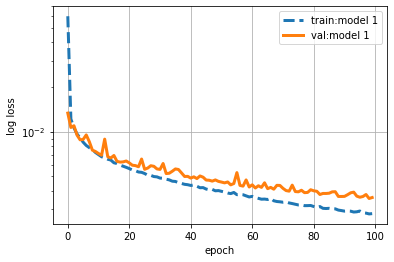

In [11]:
plot_loss(hist.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()


In [12]:
X_test , _ = load(test=True)
y_test = model.predict(X_test)

     index     0
0  ImageId  1783
1    Image  1783


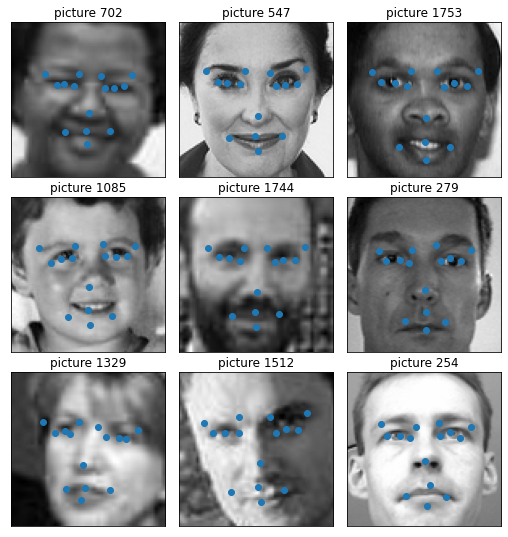

In [13]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [0]:
from keras.models import model_from_json

def save_model(model,name):
    '''
    save model architecture and model weights
    '''
    json_string = model.to_json()
    open(name+'_architecture.json', 'w').write(json_string)
    model.save_weights(name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open(name+'_architecture.json').read())
    model.load_weights(name + '_weights.h5')
    return(model)

save_model(model,"model1")
model = load_model("model1")

In [0]:
del X, y, X_test, y_test

In [16]:
## load data
X, y = load2d()
X.shape

                        index     0
0           left_eye_center_x  7039
1           left_eye_center_y  7039
2          right_eye_center_x  7036
3          right_eye_center_y  7036
4     left_eye_inner_corner_x  2271
5     left_eye_inner_corner_y  2271
6     left_eye_outer_corner_x  2267
7     left_eye_outer_corner_y  2267
8    right_eye_inner_corner_x  2268
9    right_eye_inner_corner_y  2268
10   right_eye_outer_corner_x  2268
11   right_eye_outer_corner_y  2268
12   left_eyebrow_inner_end_x  2270
13   left_eyebrow_inner_end_y  2270
14   left_eyebrow_outer_end_x  2225
15   left_eyebrow_outer_end_y  2225
16  right_eyebrow_inner_end_x  2270
17  right_eyebrow_inner_end_y  2270
18  right_eyebrow_outer_end_x  2236
19  right_eyebrow_outer_end_y  2236
20                 nose_tip_x  7049
21                 nose_tip_y  7049
22        mouth_left_corner_x  2269
23        mouth_left_corner_y  2269
24       mouth_right_corner_x  2270
25       mouth_right_corner_y  2270
26     mouth_center_top_lip_

(2140, 96, 96, 1)

In [0]:
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout

def SimpleCNN(withDropout=False):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    model.add(Conv2D(32,(3, 3), input_shape = (96, 96, 1)))
    model.add(Activation('relu')) ## 96 - 3 + 2
    model.add(MaxPooling2D(pool_size = (2,2))) ## 96 - (3-1)*2
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) ## 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(30))
    sgd = SGD(lr=0.01,momentum = 0.9,nesterov=True)
    model.compile(loss="mean_squared_error",optimizer=sgd)
    return(model)

In [18]:
pip install mxnet


In [0]:
import mxnet as mx
from mxnet.gluon.model_zoo import vision
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import time 
import mxnet as mx
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from mxnet import nd, autograd, gluon, init
from sklearn.model_selection import train_test_split
import os
#use gpu for training
ctx=mx.gpu(0)
resnet = vision.resnet34_v1(pretrained=False, ctx=mx.cpu())
fine_net = resnet.features
# fine_net.add(nn.Conv2D(64,7,strides=(2,2),padding=(3,3)),resnet18.features[1:])
fine_net.add(nn.Dense(30))
lr, num_epochs = 0.001, 500
batch_size=128
loss = gloss.L2Loss()
net = fine_net
# fine-tuning
# net[0].initialize(force_reinit=True,ctx=ctx, init=init.Xavier())
# net[2].initialize(force_reinit=True,ctx=ctx, init=init.Xavier())
# net[0].collect_params().setattr('lr_mult', 10)
# net[2].collect_params().setattr('lr_mult', 10)
net.initialize(force_reinit=True,ctx=ctx, init=init.Xavier())
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':lr})
train_ls,test_ls = train(net, X_train, Y_train,num_epochs, trainer, batch_size, ctx)

In [0]:
%%time
model2 = SimpleCNN()

hist2 = model2.fit(X,y,nb_epoch=1000,validation_split=0.2,verbose=False)

In [3]:
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

NameError: ignored

In [4]:
sample1,_ = load(test=True)
sample2,_ = load2d(test=True)
y_pred1 = model.predict(sample1)
y_pred2 = model2.predict(sample2)

NameError: ignored

In [5]:
fig = plt.figure(figsize=(4, 10))
fig.subplots_adjust(hspace=0.001,wspace=0.001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 5
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(sample2.shape[0])
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])        
    plot_sample(sample1[ipic],y_pred1[ipic],ax)
    if count < 3:
        ax.set_title("model 1")
        
    count += 1
    ax = fig.add_subplot(Npicture, 2, count,xticks=[],yticks=[])  
    plot_sample(sample2[ipic],y_pred2[ipic],ax)
    if count < 3:
        ax.set_title("model 2")
    count += 1
plt.show()

NameError: ignored

In [0]:
class DataModifier(object):
    def fit(self,X_,y_):
        return(NotImplementedError)
    
class FlipPic(DataModifier):
    def __init__(self,flip_indices=None):
        if flip_indices is None:
            flip_indices = [
                (0, 2), (1, 3),
                (4, 8), (5, 9), (6, 10), (7, 11),
                (12, 16), (13, 17), (14, 18), (15, 19),
                (22, 24), (23, 25)
                ]
        
        self.flip_indices = flip_indices
        
    def fit(self,X_batch,y_batch):

        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)

        X_batch[indices] = X_batch[indices, :, ::-1,:]
        y_batch[indices, ::2] = y_batch[indices, ::2] * -1

        # flip left eye to right eye, left mouth to right mouth and so on .. 
        for a, b in self.flip_indices:
            y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )
        return X_batch, y_batch

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

NameError: ignored

In [0]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator()
modifier = FlipPic()

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(X_train[:2],y_train[:2]):
    X_batch, y_batch = modifier.fit(*batch)

    ax = fig.add_subplot(3,3, count,xticks=[],yticks=[])  
    plot_sample(X_batch[0],y_batch[0],ax)
    count += 1
    if count == 10:
        break
plt.show()

In [0]:
def fit(model,modifier,train,validation,
        batch_size=32,epochs=2000,print_every=10,patience=np.Inf):
    '''
    model :        keras model object
    Modifier:      DataModifier() object
    train:         tuple containing two numpy arrays (X_train,y_train)
    validation:    tuple containing two numpy arrays (X_val,y_val)
    patience:      The back propagation algorithm will stop if the val_loss does not decrease 
                   after  epochs
    '''
    
    ## manually write fit method
    X_train,y_train = train
    X_val, y_val    = validation
    
    generator = ImageDataGenerator()
    
    history = {"loss":[],"val_loss":[]}
    for e in range(epochs):
        if e % print_every == 0:
            print('Epoch {:4}:'.format(e)), 
        ## -------- ##
        ## training
        ## -------- ##
        batches = 0
        loss_epoch = []
        for X_batch, y_batch in generator.flow(X_train, y_train, batch_size=batch_size):
            X_batch, y_batch = modifier.fit(X_batch, y_batch)
            hist = model.fit(X_batch, y_batch,verbose=False,epochs=1)
            loss_epoch.extend(hist.history["loss"])
            batches += 1
            if batches >= len(X_train) / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break   
        loss = np.mean(loss_epoch)
        history["loss"].append(loss)
        ## --------- ##
        ## validation
        ## --------- ##
        y_pred = model.predict(X_val)
        val_loss = np.mean((y_pred - y_val)**2)
        history["val_loss"].append(val_loss)
        if e % print_every == 0:
            print("loss - {:6.5f}, val_loss - {:6.5f}".format(loss,val_loss))
        min_val_loss = np.min(history["val_loss"])
        ## Early stopping
        if patience is not np.Inf:
            if np.all(min_val_loss < np.array(history["val_loss"])[-patience:]):
                break
    return(history)

In [0]:
%%time
#X, y = load2d()
model3 = SimpleCNN()
hist3 = fit(model3,modifier,
           train=(X_train,y_train),
           validation=(X_val,y_val),
           batch_size=32,epochs=2000,print_every=100
           )

In [0]:
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)
plot_loss(hist3,"model 3",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [0]:
class ShiftFlipPic(FlipPic):
    def __init__(self,flip_indices=None,prop=0.1):
        super(ShiftFlipPic,self).__init__(flip_indices)
        self.prop = prop
        
    def fit(self,X,y):
        X, y = super(ShiftFlipPic,self).fit(X,y)
        X, y = self.shift_image(X,y,prop=self.prop)
        return(X,y)
    def random_shift(self,shift_range,n=96):
        '''
        :param shift_range: 
        The maximum number of columns/rows to shift
        :return: 
        keep(0):   minimum row/column index to keep
        keep(1):   maximum row/column index to keep
        assign(0): minimum row/column index to assign
        assign(1): maximum row/column index to assign
        shift:     amount to shift the landmark

        assign(1) - assign(0) == keep(1) - keep(0)
        '''
        shift = np.random.randint(-shift_range,
                                  shift_range)
        def shift_left(n,shift):
            shift = np.abs(shift)
            return(0,n - shift)
        def shift_right(n,shift):
            shift = np.abs(shift)
            return(shift,n)

        if shift < 0:
            keep = shift_left(n,shift) 
            assign = shift_right(n,shift)
        else:
            assign = shift_left(n,shift) ## less than 96
            keep = shift_right(n,shift)

        return((keep,  assign, shift))

    def shift_single_image(self,x_,y_,prop=0.1):
        '''
        :param x_: a single picture array (96, 96, 1)
        :param y_: 15 landmark locations 
                   [0::2] contains x axis values
                   [1::2] contains y axis values 
        :param prop: proportion of random horizontal and vertical shift
                     relative to the number of columns
                     e.g. prop = 0.1 then the picture is moved at least by 
                     0.1*96 = 8 columns/rows
        :return: 
        x_, y_
        '''
        w_shift_max = int(x_.shape[0] * prop)
        h_shift_max = int(x_.shape[1] * prop)

        w_keep,w_assign,w_shift = self.random_shift(w_shift_max)
        h_keep,h_assign,h_shift = self.random_shift(h_shift_max)

        x_[w_assign[0]:w_assign[1],
           h_assign[0]:h_assign[1],:] = x_[w_keep[0]:w_keep[1],
                                           h_keep[0]:h_keep[1],:]

        y_[0::2] = y_[0::2] - h_shift/float(x_.shape[0]/2.)
        y_[1::2] = y_[1::2] - w_shift/float(x_.shape[1]/2.)
        return(x_,y_)

    def shift_image(self,X,y,prop=0.1):
            ## This function may be modified to be more efficient e.g. get rid of loop?
            for irow in range(X.shape[0]):
                x_ = X[irow]
                y_ = y[irow]
                X[irow],y[irow] = self.shift_single_image(x_,y_,prop=prop)
            return(X,y)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator()
shiftFlipPic = ShiftFlipPic(prop=0.1)

fig = plt.figure(figsize=(7,7))

count = 1
for batch in generator.flow(X_train[:2],y_train[:2]):
    X_batch, y_batch = shiftFlipPic.fit(*batch)

    ax = fig.add_subplot(3,3, count,xticks=[],yticks=[])  
    plot_sample(X_batch[0],y_batch[0],ax)
    count += 1
    if count == 10:
        break
plt.show()

In [0]:
%%time
model4 = SimpleCNN()
hist4 = fit(model4,shiftFlipPic,
           train=(X_train,y_train),
           validation=(X_val,y_val),
           batch_size=32,epochs=3000,print_every=50,patience=100)

In [0]:
plt.figure(figsize=(8,8))
plot_loss(hist.history,"model 1",plt)
plot_loss(hist2.history,"model 2",plt)
plot_loss(hist3,"model 3",plt)
plot_loss(hist4,"model 4",plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [0]:
save_model(model4,"model4")

In [0]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

from collections import OrderedDict

def fit_specialists(freeze=True,
                    print_every=50,
                    epochs=3000,
                    prop=0.1,
                    name_transfer_model="model4"):
    specialists = OrderedDict()
 

    for setting in SPECIALIST_SETTINGS:
        
        cols = setting['columns']
        flip_indices = setting['flip_indices']
        
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
        model = load_model(name_transfer_model) 
        if freeze:
            for layer in model.layers:
                layer.trainable = False
            
        model.layers.pop() # get rid of output layer
        model.outputs = [model.layers[-1].output]
        model.layers[-1].outbound_nodes = []
        model.add(Dense(len(cols))) # add new output layer

        model.compile(loss='mean_squared_error', optimizer="adam")
        
        shiftFlipPic = ShiftFlipPic(flip_indices=flip_indices,
                                    prop=prop)
        
        ## print(model.summary())
        hist = fit(model,shiftFlipPic,
                    train=(X_train,y_train),
                    validation=(X_val,y_val),
                    batch_size=32,epochs=epochs,
                    print_every=print_every) 
        
       
        specialists[cols] = {"model":model,
                             "hist":hist}
    return(specialists)

In [0]:
%%time
specialists1 = fit_specialists(freeze=True,
                    print_every=50,
                    epochs=500,
                    name_transfer_model="model4")

In [0]:
 def plot_specialist(specialists1,plt):   
    i = 1
    for key , value in specialists1.items():
        plot_loss(value["hist"],key[0] + str(len(key)),plt)
        i += 1

    plt.legend()
    plt.grid()
    plt.set_yscale("log")
    plt.set_xlabel("epoch")
    plt.set_ylabel("loss")
  
fig = plt.figure(figsize=(10,10))  
ax = fig.add_subplot(1,1,1)
ax.set_ylim(7**(-4),10**(-2))
plot_specialist(specialists1,ax)
plt.show()

In [0]:
from pandas import DataFrame, concat

X_test,_ = load2d(test=True)

## prediction with model 4
y_pred4 = model4.predict(X_test)
landmark_nm = read_csv(os.path.expanduser(FTRAIN)).columns[:-1].values
df_y_pred4 = DataFrame(y_pred4,columns = landmark_nm)

## prediction with specialist model
def predict_specialist(specialists1,X_test):
    y_pred_s = []
    for columns, value in specialists1.items():
        smodel = value["model"]

        y_pred = smodel.predict(X_test)
        y_pred = DataFrame(y_pred,columns=columns)
        y_pred_s.append(y_pred)

    df_y_pred_s = concat(y_pred_s,axis=1)
    return(df_y_pred_s)
df_y_pred_s = predict_specialist(specialists1,X_test)
y_pred_s = df_y_pred_s.values

In [0]:
IdLookup = read_csv(os.path.expanduser(FIdLookup))

def prepare_submission(y_pred4,filename):
    '''
    save a .csv file that can be submitted to kaggle
    '''
    ImageId = IdLookup["ImageId"]
    FeatureName = IdLookup["FeatureName"]
    RowId = IdLookup["RowId"]
    
    submit = []
    for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
        submit.append([rowId,y_pred4[landmark].iloc[irow-1]])
    
    submit = DataFrame(submit,columns=["RowId","Location"])
    ## adjust the scale 
    submit["Location"] = submit["Location"]*48 + 48
    print(submit.shape)
    loc = "result/" + filename + ".csv"
    submit.to_csv(loc,index=False)
    print("File is saved at:" +  loc)
    
prepare_submission(df_y_pred4,"model4")
prepare_submission(df_y_pred_s,"special")

In [0]:
## reorder the columns of df_y_pred_s
df_y_pred_s = df_y_pred_s[df_y_pred4.columns]
df_compare = {}
df_compare["difference"] = ((df_y_pred_s - df_y_pred4)**2).mean(axis=1)
df_compare["RowId"] = range(df_y_pred_s.shape[0])
df_compare = DataFrame(df_compare)
df_compare = df_compare.sort_values("difference",ascending=False)

In [0]:
fig = plt.figure(figsize=(12,35))

Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):
    ## bad model 4
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred4[ipic_g],ax)
    ax.set_title("Good:model4:pic"+str(ipic_g))
    
    ## bad special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic_g],y_pred_s[ipic_g],ax)
    ax.set_title("Good:special:pic"+str(ipic_g))
    
    ## bad model 4
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred4[ipic],ax)
    ax.set_title("Bad:model4:pic"+str(ipic))
    
    ## bad special
    ax = fig.add_subplot(Nsample,4,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special:pic"+str(ipic))

plt.show()

In [0]:
%%time
specialists2 = fit_specialists(freeze=False,
                    print_every=50,
                    epochs=300,
                    prop=0.2,
                    name_transfer_model="model4")


In [0]:
ylim = (7**(-4),10**(-2))
fig = plt.figure(figsize=(20,10))  

ax = fig.add_subplot(1,2,1)
ax.set_ylim(ylim)
ax.set_title("specialist 1")
plot_specialist(specialists1,ax)

ax = fig.add_subplot(1,2,2)
ax.set_ylim(ylim)
ax.set_title("specialist 2")
plot_specialist(specialists2,ax)

plt.show()


In [0]:
df_y_pred_s2 = predict_specialist(specialists2,X_test)
prepare_submission(df_y_pred_s2,"special2")

In [0]:
fig = plt.figure(figsize=(7,35))
y_pred_s2 = df_y_pred_s2.values
Nsample = 13
pic_index = df_compare["RowId"].iloc[:Nsample].values
pic_index_good = df_compare["RowId"].iloc[-Nsample:].values
count = 1


for ipic_g,ipic in zip(pic_index_good,pic_index):

    ax = fig.add_subplot(Nsample,2,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s[ipic],ax)
    ax.set_title("Bad:special1:pic"+str(ipic))
    
    ax = fig.add_subplot(Nsample,2,count,xticks=[],yticks=[])
    count += 1
    plot_sample(X_test[ipic],y_pred_s2[ipic],ax)
    ax.set_title("Bad:special2:pic"+str(ipic))
    
    

    
   
plt.show()